In [1]:
# data processing
import pandas as pd
import numpy as np

# modelling
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, auc, roc_curve, accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mnist = keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()

Dataset split: 60000 train rows
Dataset split: 10000 test rows


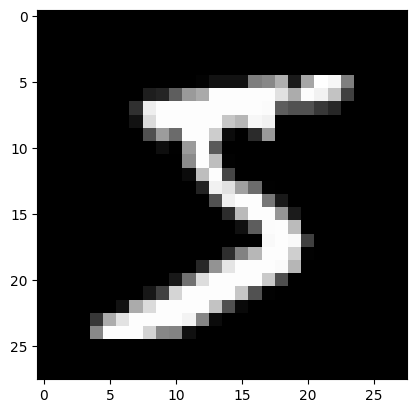

In [3]:
print(f"Dataset split: {len(x_train)} train rows")
print(f"Dataset split: {len(x_test)} test rows")

point = x_train[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [4]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [5]:
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [6]:
input_img = keras.layers.Input(shape=(784,))
encoded = keras.layers.Dense(256, activation='relu')(input_img)
encoded = keras.layers.Dense(128, activation='relu')(encoded)
encoded = keras.layers.Dense(64, activation='relu')(encoded)
encoded = keras.layers.Dense(32, activation='relu')(encoded)

In [7]:
decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(128, activation='relu')(decoded)
decoded = keras.layers.Dense(256, activation='relu')(decoded)
decoded = keras.layers.Dense(784, activation='sigmoid')(decoded)

In [8]:
autoencoder = keras.models.Model(input_img, decoded)

In [9]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
autoencoder.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0639 - val_loss: 0.0366
Epoch 2/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0303 - val_loss: 0.0251
Epoch 3/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0231 - val_loss: 0.0206
Epoch 4/10
235/235 [==============================] - 3s 11ms/step - loss: 0.0196 - val_loss: 0.0185
Epoch 5/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0179 - val_loss: 0.0168
Epoch 6/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0167 - val_loss: 0.0160
Epoch 7/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0158 - val_loss: 0.0149
Epoch 8/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 9/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 10/10
235/235 [==============================] - 2s 10ms/step - loss: 0.0134 - val_lo

In [11]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [12]:
reconstruction_errors = np.mean(np.square(x_test - decoded_imgs), axis=1)

In [13]:
threshold = np.percentile(reconstruction_errors, 95)

In [14]:
# Identify anomalies based on the threshold
anomaly_indexes = np.where(reconstruction_errors > threshold)[0]

In [15]:
# Get all the anomalies from the test_images
anomalies = x_test[anomaly_indexes]

In [16]:
# Save the anomaly indexes to a file
with open("anomaly_indexes.txt", "w") as file:
    for idx in anomaly_indexes:
        file.write(str(idx) + "\n")

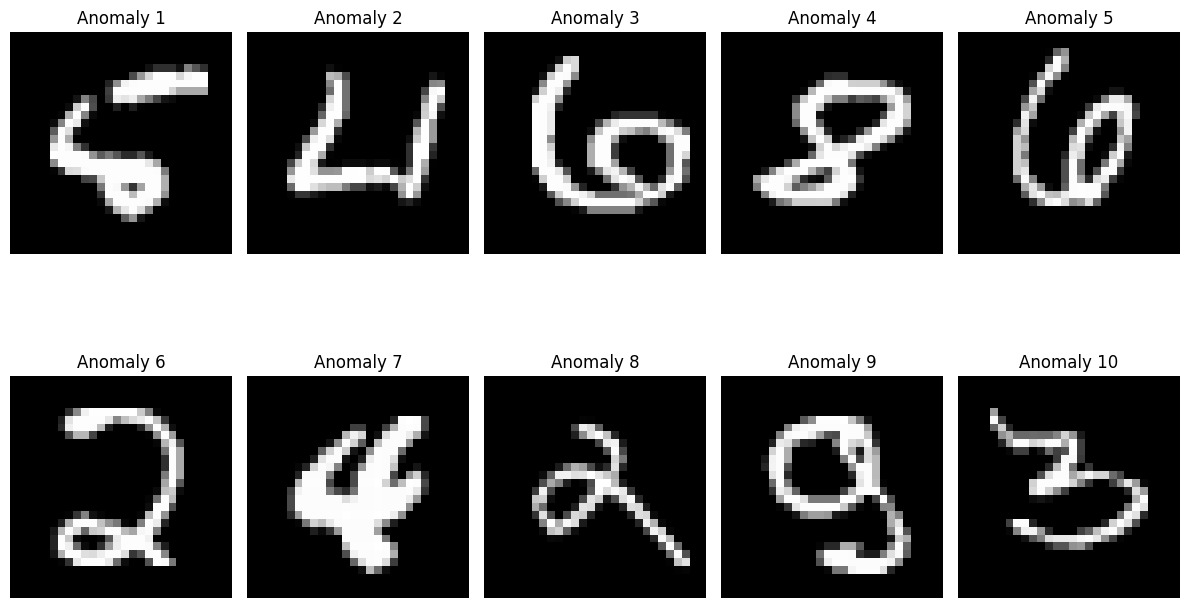

In [17]:
# Plot some of the anomalies
plt.figure(figsize=(12, 8))
for i, idx in enumerate(anomaly_indexes[:10]):  # Plot the first 10 anomaly indices
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Anomaly {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

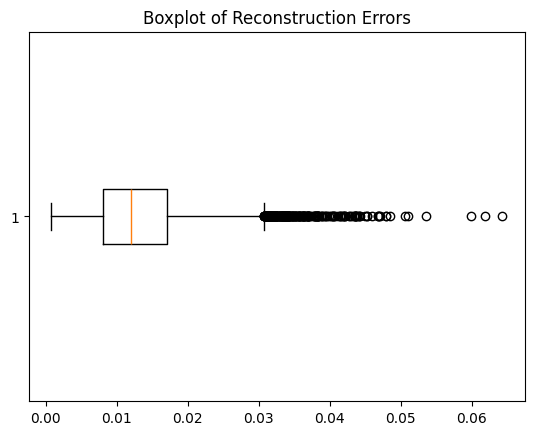

In [18]:
# Add a boxplot using reconstruction error values
plt.boxplot(reconstruction_errors, vert=False)
plt.title("Boxplot of Reconstruction Errors")
plt.show()

In [19]:
# Make a ROC curve and calculate the area under the curve (AUC)
y_true = [1 if i in anomalies else 0 for i in range(len(x_test))]

fpr, tpr, _ = roc_curve(y_true, reconstruction_errors)
roc_auc = auc(fpr, tpr)

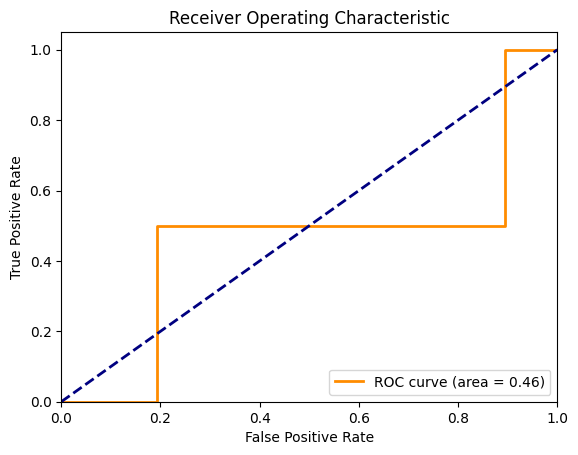

In [20]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [22]:
# classification report, binary labels where 1 represents anomalies and 0 represents non-anomalies
anomaly_labels = np.where(reconstruction_errors > threshold, 1, 0)
report = classification_report(y_true, anomaly_labels)
print(report)


              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9998
           1       0.00      0.00      0.00         2

    accuracy                           0.95     10000
   macro avg       0.50      0.47      0.49     10000
weighted avg       1.00      0.95      0.97     10000

